# Summary
This notebook replicates the interpretation of discovered subspaces in RNA-seq data using the additional patient clinical information.

In [1]:
import sys
sys.path.append("..")

#GPU configuration
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default

import random
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import adjusted_rand_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import scripts.data_generator as data_generator
import scripts.feature_ranking as feature_ranking
import scripts.features_2d as features_2d
import scripts.ga as ga
import scripts.preprocess as preprocess
import scripts.ga_evaluation as ga_evaluation
import scripts.bio_analysis as bio_analysis
import tensorflow as tf
from IPython import get_ipython
from tqdm import tqdm
from collections import Counter

plt.ion()
plt.show()

random_state=0
random.seed( random_state )
np.random.seed(random_state)

%load_ext autoreload
%autoreload 2

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5



Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [2]:
maping = {
    'breast_carcinoma_estrogen_receptor_status': "Carcinoma Estrogen Receptor",
    'metastatic_site_at_diagnosis-2': "Metastatic site 2",
    'bcr_canonical_reason': "Canonical reason",
    'anatomic_neoplasm_subdivision-4': "Neoplasm subdivision 4",
    'pos_finding_her2_erbb2_other_measurement_scale_text': "Her2 Erbb2",
    'bcr_canonical_reason-2': "Canonical reason 2",
    "days_to_additional_surgery_metastatic_procedure":
    "Days to additional surgery",
    "metastatic_site_at_diagnosis_other": "Metastatic site",
    'bcr_patient_canonical_status': "BCR Canonical Status",
    'bcr_canonical_reason-2': "BCR Canonical Reason 2",
    'erythrocyte_sedimentation_rate_result': "Erythrocyte Sedimentation",
    'gender': "Gender",
    'clinical_stage': "Clinical Stage",
    'karnofsky_performance_score': "Karnofsky performance",
    'serum_calcium_result': "Serum Calcium Result",
    'lymph_node_examined_count': "Lymph count",
    'eastern_cancer_oncology_group': "Eastern oncology group",
    'days_to_death': "Days to death",
    'year_of_tobacco_smoking_onset': "Year smoking onset",
    'followup_treatment_success': "Followup treatment success",
    'performance_status_scale_timing': "Status Scale Timing",
    "additional_surgery_locoregional_procedure": "Additional Locoregional Procedure",
    "number_of_lymphnodes_positive": "Nb positives lymphnodes",
    "lactate_dehydrogenase_result": "Lactate dehydrogenase"
}

Found 2 values for vital_status
Clustering numeric values for days_to_death
Clustering numeric values for days_to_last_followup
No more than 1 class found for additional_studies
Found 3 values for additional_surgery_locoregional_procedure
No more than 1 class found for additional_surgery_metastatic_procedure
Clustering numeric values for age_at_initial_pathologic_diagnosis
Found 11 values for anatomic_neoplasm_subdivision-2
Found 9 values for anatomic_neoplasm_subdivision-3
Found 6 values for anatomic_neoplasm_subdivision-4
Found 5 values for anatomic_neoplasm_subdivision-5
Found 10 values for anatomic_neoplasm_subdivision
Found 6 values for axillary_lymph_node_stage_method_type
Found 19 values for axillary_lymph_node_stage_other_method_descriptive_text
No more than 1 class found for b_symptoms
No more than 1 class found for bcr
Found 3 values for bcr_canonical_reason-2
No more than 1 class found for bcr_canonical_reason-3
Found 6 values for bcr_canonical_reason
Found 942 values for bc

Clustering numeric values for number_pack_years_smoked
Found 4 values for other_dx
Found 4 values for pathologic_m
Found 5 values for pathologic_n
Found 5 values for pathologic_stage
Found 11 values for pathologic_t
Found 5 values for performance_status_scale_timing
Found 3 values for person_neoplasm_cancer_status
Found 4 values for platelet_qualitative_result
Found 3 values for primary_lymph_node_presentation_assessment
No more than 1 class found for primary_pattern
Found 5 values for primary_therapy_outcome_success
No more than 1 class found for project_code
No more than 1 class found for psa_value
Found 5 values for race
No more than 1 class found for radiation_therapy
No more than 1 class found for radiation_type_notes
No more than 1 class found for radiations
No more than 1 class found for secondary_pattern
Found 4 values for serum_calcium_result
No more than 1 class found for serum_markers
Clustering numeric values for stopped_smoking_year
Found 5 values for system_version
Found 

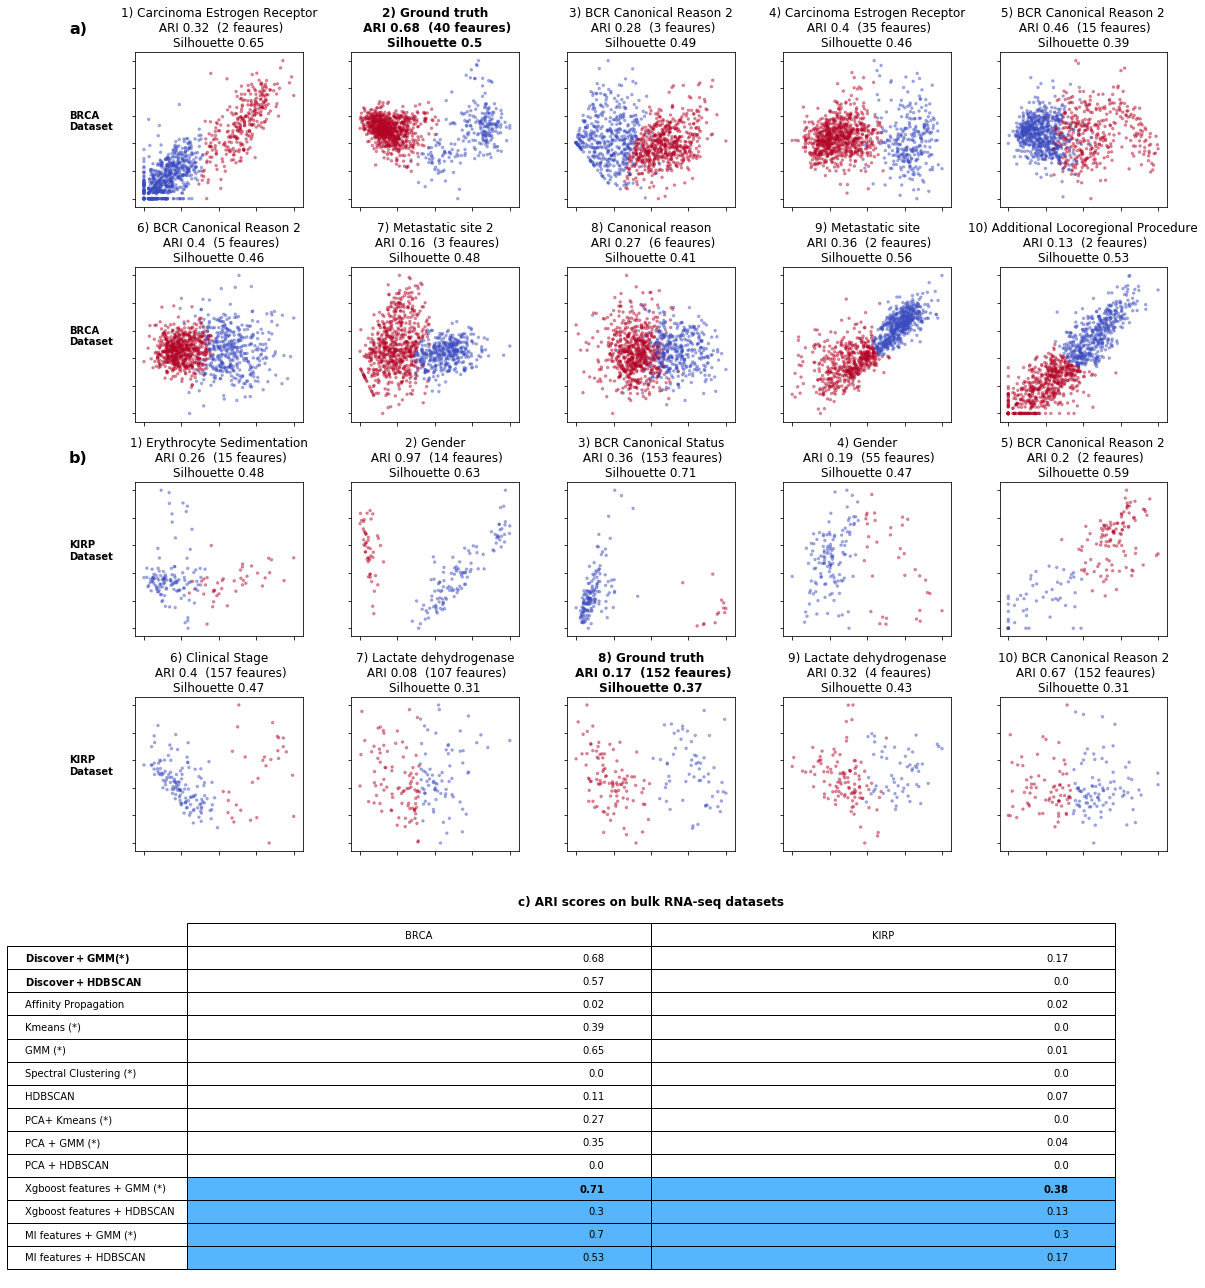

In [54]:
ncols = 5
nrows = 6
letters = ["a)", "b)"]
fig=plt.figure(figsize = (16, nrows * 3) )
gs = fig.add_gridspec(nrows, ncols)
for di, filename in enumerate(["BRCA", "KIRP"]):

    ground_truth_column = {"BRCA":"breast_carcinoma_estrogen_receptor_status", "KIRP": "tumor_type"}
    ground_truth_column = ground_truth_column[filename]


    data = pd.read_pickle(f"../data/rna_data/{filename}.pkl")
    additional_df = pd.read_pickle(f"../data/rna_data/{filename}_additional.pkl")
    truth = data["y"].values
    data = data.drop("y", axis = 1).values
    n_clusters = len(np.unique(truth))
    Counter(truth), data.shape

    clustering = "gmm"
    method = "adapted_ratkowsky_lance"

    solutions = pd.read_pickle(f"../data/{filename}_{clustering}_{method}.pkl")
    solutions = ga.rank_solutions(solutions, data)
    ground_truth_nb = solutions[solutions["rank_ari"] == 1].index.values[0]

    subspaces = solutions["features"].values
    partitions = solutions["partition"].values

    additional_results, best_subspace_match, best_meta_subspace = bio_analysis.clinical_data_analysis(
        additional_df, solutions, n_clusters)
    subspaces = solutions["features"].values
    partitions = solutions["partition"].values
    silhouette = solutions["silhouette"].values.round(2)
    scores = solutions[solutions.columns[0]].values

    for k, subspace in enumerate(subspaces):
        cur_row = di*2 + k//ncols
        cur_col = k%ncols
        data_x = data[:, subspace]
        if len(subspace) ==2:
            pca_data= data[:, subspace]
        else:
            pca_data = PCA(n_components=2).fit_transform(data_x)
        pca_data = MinMaxScaler().fit_transform(pca_data)

        predK = partitions[k]
#         predK = KMeans(n_clusters=n_clusters,
#                            random_state=0).fit(data_x).labels_
        title = maping[best_subspace_match["additional_data" ].values[k]]

        score = best_subspace_match['ari'].values[k]
        sil = silhouette[k]
#         ax= plt.subplot(nrows, ncols, k+1)
        ax = fig.add_subplot(gs[cur_row, cur_col])
        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])
        if k%ncols ==0 :
            plt.text( -0.5, 0.5, f"{filename}\nDataset", fontweight = "bold")
            if k == 0:
                plt.text( -0.5, 1.2, f"{letters[di]}", fontweight = "bold", fontsize = 16)
        if k!= ground_truth_nb:
            fontweight = "normal"  
        else: 
            fontweight = "bold"
            score = solutions["ari"].values.round(2)[k]
            title = "Ground truth"
        plt.title(
            f"{k+1}) {title}\n ARI {score}  ({len(subspace)} feaures)\nSilhouette {sil}",
            fontweight = fontweight
        )
        plt.scatter(pca_data[:, 0], pca_data[:, 1], c=predK, cmap = "coolwarm", alpha = 0.4, s = 6)
        
        
df = pd.read_excel("../results.xlsx", sheet_name = 1)
df["Dataset Index"] = df["Dataset name"].apply(lambda x: "$\\bf{" + x+  "}$" if x.startswith("Discover") else x)

df = df.set_index("Dataset Index", drop = True)

numeric_scores = df.values[:,1: -1]

values = [" "*20] * numeric_scores.shape[0]* numeric_scores.shape[1]
values = np.array(values).reshape(numeric_scores.shape)

for i in range(numeric_scores.shape[1]):
    for j in range(numeric_scores.shape[0]):
        values[ j, i] = str(numeric_scores[ j, i])
    j = np.argmax(numeric_scores[:, i])
    values[ j, i]= "$\\bf{" + str(numeric_scores[ j, i]) +  "}$"

ax = fig.add_subplot(gs[-2:, :])
ax.axis("off")
plt.title("c) ARI scores on bulk RNA-seq datasets", fontweight = "bold")
table = ax.table(cellText=values,
          rowLabels=df.index,
          colLabels=df.columns[1:],
          loc='center',
          fontsize = 20  
        )
table.scale(0.9, 1.6)
for r in range(len(values)-3, len(values)+1):
    for c in range(values.shape[1]):
        table[(r, c)].set_facecolor("#56b5fd")
        
plt.tight_layout()

plt.savefig(f"../images/RNA-seq.pdf", bbox_inches='tight')


    

In [ ]:
bio_analysis.plot_subspaces_with_best_meta(solutions,
                                           best_subspace_match,
                                           data,
                                           ground_truth_subspace,
                                           maping,
                                           do_pca=True,
                                           filename =  f"../images/{filename}_subspaces_PCA.jpg")

In [ ]:
bio_analysis.plot_prediction_vs_ground_truth(ground_truth_subspace, solutions, data, truth, do_pca = True,
            filename = f"../images/{filename}_pred_vs_gt.pdf")


In [ ]:
bio_analysis.solutions_to_survival_analysis(
    additional_df, solutions, f"../data/rna_data/{filename}_survival.pkl")

In [ ]:
pdf_name =f"reports/{filename}.pdf"
bio_analysis.plot_pca_subspaces(data, solutions, method, truth, pdf_name = None, name = filename)

In [ ]:
merged = bio_analysis.merge_subspaces(solutions, method, data, n_clusters, truth)

# Gender analysis

In [ ]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import fcluster, linkage
from sklearn import cluster, datasets, mixture

In [ ]:
c = 'gender'

additional_df['gender' ].isnull().sum()

not_null_idx = additional_df[~additional_df[c].isnull(
            )].index.values

labels = preprocessing.LabelEncoder().fit_transform(
                    additional_df[c].values[not_null_idx])

In [ ]:
# for i in range(20):
#     print(i, adjusted_rand_score(labels, solutions.iloc[i]['partition']))

In [ ]:
sid = 3

target_subspace = solutions.iloc[sid]['features']

adjusted_rand_score(labels, solutions.iloc[sid]['partition']), len(target_subspace)

In [ ]:
labels = np.abs(labels -1)

In [ ]:
mislabelled = np.where(labels!= solutions.iloc[sid]['partition'])[0]

In [ ]:
len(mislabelled)

In [ ]:
do_pca = True
data_x = data[:, target_subspace]
if do_pca:
    pca_data = PCA(n_components=2).fit_transform(data_x)
else:
    pca_data = TSNE(n_components=2).fit_transform(data_x)

In [ ]:
plt.scatter(pca_data[:, 0], pca_data[:, 1], c= solutions.iloc[sid]['partition'], 
            cmap = "coolwarm", alpha = 0.6, s = 15)
plt.scatter(pca_data[mislabelled, 0], pca_data[mislabelled, 1], c = "black", marker = '*', s =150) 
plt.title("Gender analysis")

plt.savefig("../images/gender_analysis.pdf", bbox_inches='tight')